# Computing the height of the intersection between the projective line $(x_0+x_1+x_2=0)\subset\mathbb{P}^2$ and its translates by torsion points

### Roberto Gualdi and Martín Sombra

_Notebook run over SageMath 8.4_

## Abstract

This notebook provides the companion code for the paper "**Limit heights and special values of the Riemann Zeta function**" [GS] from the same authors, which studies the canonical height of the intersection point $P(\omega)$ between the projective plane lines

$$(x_0+x_1+x_2=0)\quad\text{ and }\quad \big(x_0+\omega_1^{-1}x_1+\omega_2^{-1}x_2=0\big)$$

as $\omega=(\omega_1,\omega_2)$ ranges in the set of nontrivial torsion points of the two-dimensional multiplicative torus.

In practise, the major function that we define in this notebook is `height_values`.
For an input consisting of a positive integer $d$ and a positive real number $\varepsilon$, this function graphically displays the height of $P(\omega)$ for all nontrivial $d$-torsion points $\omega$ and computes the portion of such $\omega$'s for which the height of $P(\omega)$ is in a $\varepsilon$-neighbourhood of the expected value $$\frac{2\zeta(3)}{3\zeta(2)},$$ as predicted by [GS, Theorem 1].

We also give a function `evolution_averages` picturing the asymptotic behaviour, as $d$ grows, of the average height values given by nontrivial $d$-torsion points and of the percentage of them being close to the expected value.

## The code

### Initialization

We start by defining the setting and the constants that will be needed in the code, as well as importing the Python library `random` that will be used to shuffle the array of the height values when producing a graphical result.

In [1]:
RR = RealField(30)
CC = ComplexField(30)
i = CC(i)
pi = RR(pi)

import random

### The height of a point

We then go on by coding a function which computed the height of the points we are interested in.
Let us fix for the moment a positive integer $d$, and a primitive $d$-root of unity $\zeta$. Our first objective is to define a function `H(d,a,b)` that for all pair of integers $a,b\in\{0,\ldots,d-1\}$ with $(a,b)\neq(0,0)$ gives the canonical height of the projective point

$$P(\zeta^a,\zeta^b)=\big[\zeta^{-b}-\zeta^{-a}:1-\zeta^{-b}:\zeta^{-a}-1\big].$$

Notice that the invariance of the height under Galois conjugation [BG, Proposition 1.5.17] yields the independence of this value from the choice of $\zeta$ among the primitive $d$-roots of unity.

To compute the height of $P(\zeta^a,\zeta^b)$, we use its explicit expression from [GS].
More precisely, we start by remarking that for all $a,b$ as before the torsion point $(\zeta^a,\zeta^b)$ has order $e=d/\gcd(a,b,d)$.
Therefore, considering the von Mangoldt function

$$\Lambda(e)=\begin{cases}\log p&\text{if $e$ is a $p$-power}\\0&\text{otherwise}\end{cases},$$

[GS, Lemma 2.3 and Corollary 3.4] combine to give

$$\text{h}(P(\zeta^a,\zeta^b))=-\frac{\Lambda(e)}{\varphi(e)}+\frac{1}{\varphi(e)}\sum_{\substack{k=1,\ldots,e\\(k,e)=1}} \log \max \big(\big|e^{2\pi ibk/d}-e^{2\pi iak/d}\big|, \big|e^{2\pi ibk/d}-1\big|,\big|e^{2\pi iak/d}-1\big|\big).$$

This computation can be easily coded in the function `H(d,a,b)`. For clarity, we call `G(e)` the function calculating the first summand in the above expression, and `F(d,a,b,k)` the one giving the $k$-th term in the second one. When computing `H(d,a,b)`, the Euler function for $e$ is tracked by the variable `Phi`, whose final value is precisely $\varphi(e)$.

In [2]:
def F(d,a,b,k):
    return log( max( abs(exp(2*pi*i*b*k/d) - exp(2*pi*i*a*k/d)), abs(exp(2*pi*i*b*k/d) - 1), abs(exp(2*pi*i*a*k/d) - 1) ) )

def G(e):
    a = is_prime_power(e, get_data=True)
    p = a[0]
    k = a[1]
    if k == 0:
        return 0
    else:
        return log(p)/(p^(k-1)*(p-1))

def H(d,a,b):
    Phi= 0 
    S = 0
    e =  d/gcd([a,b,d])
    for k in [1..e-1]:
        if gcd(k,e) == 1:
            Phi = Phi + 1
            S = S + F(d,a,b,k)
    return -G(e) + (S/Phi)

### The function `height_values`

We are now ready to define the main function of the code, which essentially computes the height of the point $P(\omega)$ for all nontrivial $d$-torsion points $\omega$, for a given positive integer $d$.
In practice, the script produces a $d\times d$ matrix $A$ with entries

$$A_{a,b}:=
\begin{cases}
\text{h}(P(\zeta^{a},\zeta^{b}))&\text{if }(a,b)\neq(0,0)
\\0&\text{otherwise}
\end{cases}$$

for all $a,b=0\ldots,d-1$.
In the above expression, $\zeta$ denotes a primitive root of unity in $\overline{\mathbb{Q}}$; as already remarked above, the matrix does not depend on such a choice thanks to the invariance of the height under Galois conjugation.
For convenience, we also collect the entries of $A$ (except for the conventional $A_{0,0}$) in a single vector $v$ of length $d^2-1$.

#### On the computation of the matrix

We explain here how we optimize the computation of $A$.
To start with, we already know from [GS, Proposition 2.2] that the height of $P(\zeta^a,\zeta^b)$ is zero when $a=0$, $b=0$ or $a=b$. Moreover, the height of $P(\zeta^a,\zeta^b)$ equals the one of $P(\zeta^a,\zeta^b)$ for every pair of indices.
Therefore, we can restrict the computation to the cases

$$a,b\in\{1,\ldots,d-1\}\quad\text{ and }\quad b>a.$$

Moreover, the fact that the height of a point is invariant under Galois conjugation can be exploited to "propagate" a single computation to several entries of $A$.
To do this, we remark that for all $a$ and $b$ it holds that

$$P(\zeta^a,\zeta^b)=P\big(\xi^{a/\gcd(a,b,d)},\xi^{b/\gcd(a,b,d)}\big),$$

where $\xi=\zeta^{\gcd(a,b,d)}$ is a primitive root of unity of order $e=d/\gcd(a,b,d)$.
In particular, the explicit expression for $P(\zeta^a,\zeta^b)$ shows that this point has coordinates in the number field $\mathbb{Q}(\xi)$, and therefore its Galois conjugates are precisely the points

$$P\big(\xi^{ka/\gcd(a,b,d)},\xi^{kb/\gcd(a,b,d)}\big)=P(\zeta^{ka},\zeta^{kb})$$

with $k\in(\mathbb{Z}/e\mathbb{Z})^\times$.


#### Usage of  the function `height_values`

By allowing an optional argument in the code, we provide two ways to use our main function.

Calling `height_values(d,epsilon)` with arguments an integer $d\geq2$ and a real number $\varepsilon>0$, the function gives a vector of lenght two as an output.
* The first entry of the output is the average of the vector $v$, that is the average of the height values
  
  $$\text{h}(P(\omega))$$
  
  as $\omega$ ranges in the set of nontrivial $d$-torsion points of the two-dimensional multiplicative torus.
  
* The second entry of the output is the percentage of such torsion points $\omega$ for which
    
$$\bigg|\,\text{h}(P(\omega))-\frac{2\zeta(3)}{3\zeta(2)}\,\bigg|<\varepsilon.$$

Calling `height_values(d,epsilon,show_graph=True)` with arguments an integer $d\geq2$ and a real number $\varepsilon>0$, the function produces two graphs, in addition to printing the information above.
* The first graph collects (in no particular order) all the height values of the projective points $P(\omega)$ with $\omega$ raninging in the set of nontrivial $d$-torsion points of the two-dimensional multiplicative torus. In the picture, a red mark indicates the expected average value
  
  $$\frac{2\zeta(3)}{3\zeta(2)}$$
  
  while an orange one shows the Mahler measure of the polynomial $1+x+y$ (whose numerical value is taken from [Boy, equation (14)]).

* The second picture plots the matrix $A$. Otherwise said, for all $a,b=0,\ldots,d-1$ and $(a,b)\neq(0,0)$ it colors the squared cell centered at $(a,b)$ with a tone of grey that is as dark as the value
  
  $$\text{h}\big(P(\zeta^a,\zeta^b)\big)$$
  
  is high. A white cell corresponds to the value 0, while a black cell to the value log(2), which are the extrema of the height values calculated in [GS, Proposition 2.2].

In [7]:
def height_values(d, epsilon,**kwargs):
    
#1. PROLOGUE
    
    #we start by initializing the variables

    A = matrix(RR,d)
    v = vector(RR,d^2-1)
    j = 0
    graphic = False
    
    #let us check whether the user wants a graphical result
    
    for keyword, value in kwargs.iteritems():
        if keyword == 'show_graph':
            if value == True:
                graphic = True
                
#2. COMPUTATION OF THE MATRIX A AND OF THE VECTOR v

    #to fill the matrix with the values of the height, we can reduce to its upper
    #triangular part and exclude the entries with at least one coordinate being 0

    for a in [1..d-1]:
        for b in [1..a-1,a+1..d-1]:

    #the following condition ensures that the computation is performed only if the
    #height of the corresponding point has not been yet otherwise calculated

            if A[a,b] == 0:
            
                A[a,b] = H(d,a,b)
                
                #we can exploit the Galois invariance to propagate the height computation 
                
                e = d/gcd([a,b,d])
                for k in [1..e-1]:
                    if gcd(k,e) == 1:
                        A[Mod(k*a,d),Mod(k*b,d)] = A[a,b]
            
            #let us add the value just computed to the vector v
            
            v[j] = A[a,b]
            j = j + 1
            
#3. COMPUTATION OF THE OUTPUTS

    #the average is quickly computed

    average = sum(v)/(d^2-1)
    
    #we count how many height values are close to the average predicted by [GS]
    
    expectedaverage = n(2*zeta(3)/(3*zeta(2)))
    counter = 0
    for j in [0..d^2-2]:
        if abs(v[j]-expectedaverage) < epsilon:
            counter = counter + 1
    percent = n(counter*100/(d^2-1))
    
#4. OUTPUTS, INCLUDING A GRAPHICAL RENDERING OF THE RESULTS

    #in case the user does not desire any graphical result, the job
    #is over, and we can tell them the result of the computations

    if graphic == False:
        return [average, percent]

    #otherwise, we need to produce a couple of pictures

    else:
        
        #we print out some information about the collection of height values
        
        print 'd = ',d
        print 'Maximum of height values: ', max(v)
        print 'Average of height values: ', average  
        print 'For ', percent,'% of the points, the height is closer to the average than ', epsilon,'.'
        
        #FIGURE 1
        
        #a red horizontal segment marks the limit value of the average predicted by [GS]
    
        l1 = line([(0.9,expectedaverage),(1.05,expectedaverage)], color='red', thickness=2)
        
        #here also comes an orange mark indicating the approximated value of the Mahler's
        #measure of the polynomial 1+x+y, computed using equation (14) in [Boy]
        
        mahler = log(1.38135) 
        l2 = line([(0.9,mahler),(1.05,mahler)], color='orange', thickness=2)
        
        #let us shuffle the values of v for a more visual effect, and put the height
        #values as ordinates of a collection of points p with abscissa in the line
        #interval [0,1] and with thickness depending on the number of points
        
        random.shuffle(v)
        w = [(j/(d^2-1), v[j]) for j in [0..d^2-2]] 
        thickness = max(1,120/d)
        p = points(w,size=thickness)
        
        #finally we can produce the first figure
        
        g = p + l1 + l2
        g.show(xmin=0, xmax=1.1, ymin=0, ymax=0.75, ticks=[[], None])
        
        #FIGURE 2
        
        #we plot the matrix A by putting the origin on the left-bottom corner, and by coloring
        #each cell with a tone of grey which is as dark as the corresponding height value
        #(white correspond to the value 0 and black to the value log(2))
     
        h = matrix_plot(A, origin='lower', frame=False, vmin=0, vmax=log(2),zorder=0)
        
        #we have to construct "by hand" a frame for the matrix, which should turn around the cell
        #(0,0) to underline that this choice does not produce any meaningful height value
        
        sq = line([(-0.5,+0.5),(+0.5,+0.5),(+0.5,-0.5),(d-0.5,-0.5),(d-0.5,d-0.5),(-0.5,d-0.5),(-0.5,+0.5)], color='black', thickness=1, axes=False)
        
        #finally, we can depict the result
        
        show(sq + h)

We can test our function, asking it to produce a graphical visualization for a low value of $d$.

d =  30
Maximum of height values:  0.69314718
Average of height values:  0.47128239
For  47.3859844271413 % of the points, the height is closer to the average than  0.100000000000000 .


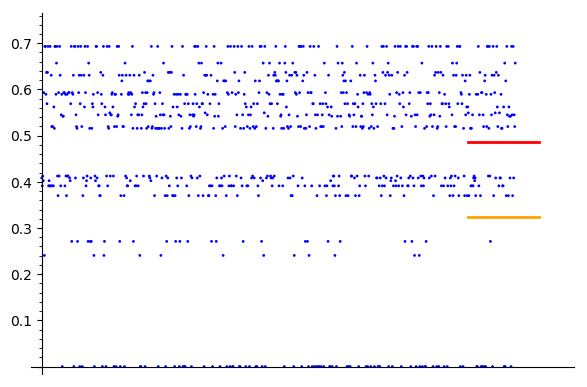

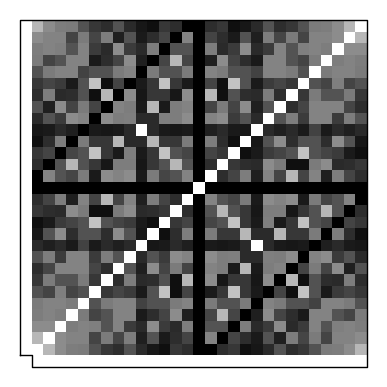

In [8]:
height_values(30, 0.1, show_graph=True)

Nothing prevents us from running the code with higher values of $d$ and finer values for $\varepsilon$, as the next line of code does.

d =  100
Maximum of height values:  0.69314718
Average of height values:  0.48100174
For  22.8022802280228 % of the points, the height is closer to the average than  0.0100000000000000 .


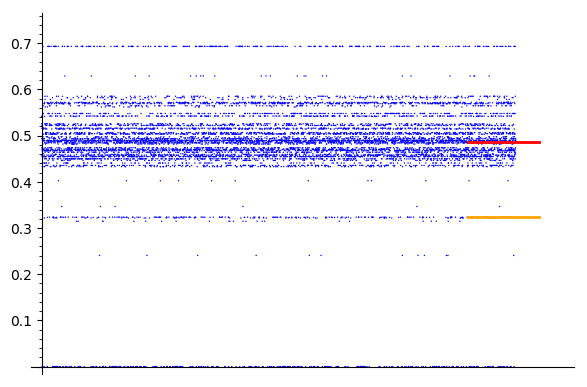

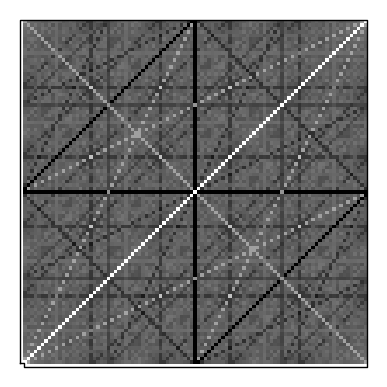

In [9]:
height_values(100, 0.01, show_graph=True)

### Asymptotics

Finally, instead of making a computation for a given integer $d$, we define a function that pictures the evolution of the previous results for increasing values of $d$.

More precisely, we define the function `evolution_averages`, which takes as input an integer $D\geq2$ and a real number $\varepsilon>0$. The function plots the results of the function `height_values(d,epsilon)` for all values of $$d\in\{2,\ldots, D\}$$ and the given $\varepsilon$.

The results are shown in two different graphs.

* The first one shows the evolution of the averages of the height values of $P(\omega)$ as $\omega$ ranges in the set of nontrivial $d$-torsion points. Moreover, a red horizontal line with the limit average $$\frac{2\zeta(3)}{3\zeta(2)}$$ from [GS, Theorem 1] is drawn.

* The second graph exhibits the evolution of the percentage of nontrivial $d$-torsion points $\omega$ for which the height of $P(\omega)$ is closer to such expected limit value than $\varepsilon$.

Since prime numbers are dear to number theorists, we color the results corresponding to prime values of $d$ in a darker shade of blue.

In [6]:
def evolution_averages(D, epsilon):
    
    #initializing the vectors containing the results

    average_primes = []
    percent_primes = []
    average_non_primes = []
    percent_non_primes = []
    
    #we let d run from 2 (the minimal values which makes sense) to D and apply
    #the function height_values to d and epsilon, taking care of storing 
    #the results in two different vectors for the prime and nonprime cases
    
    for d in [2..D]:
        
        a = height_values(d, epsilon)
        
        if d in Primes():
            
            average_primes.append([d,a[0]])
            percent_primes.append([d,a[1]])
            
        else:
            
            average_non_primes.append([d,a[0]])
            percent_non_primes.append([d,a[1]])
    
    #FIGURE 1
    
    #let us define a red horizontal segment marking the limit value of the average predicted by [GS]
    
    expectedaverage = n(2*zeta(3)/(3*zeta(2)))
    l = line([(0,expectedaverage),(D,expectedaverage)], color='red', thickness=2)
    
    #we can then draw the evolution of averages by coloring the
    #one corresponding to prime values of d in 'darkblue'
        
    p = points(average_non_primes, color='cyan') + points(average_primes,color='darkblue') + l
    p.show(title='Evolution of averages')
    
    #FIGURE 2
    
    #this is the equivalent of the previous figure,
    #depicting the evolution of percentages
    
    q = points(percent_non_primes, color='lightskyblue') + points(percent_primes,color='darkblue')
    q.show(ymin=0, ymax=100, title='Evolution of percentages')

Here is the result when running the code for the first $250$ values of $d$ and for $\varepsilon=0.1$.

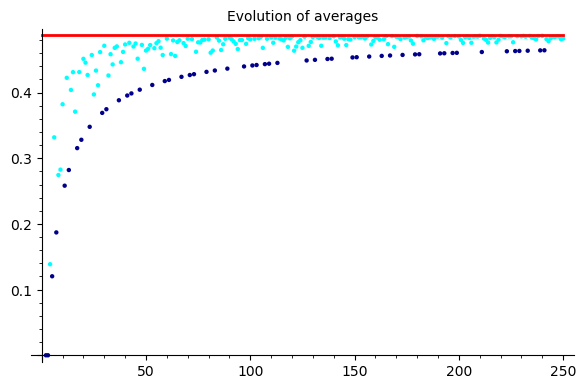

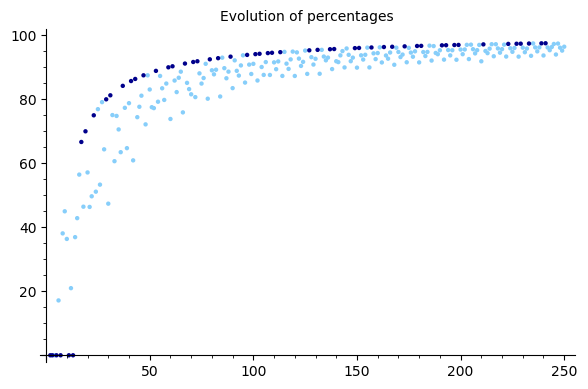

In [7]:
evolution_averages(250, 0.1)

Remarks about the graphical results obtained here and guesses related to them are discussed more extensively in [GS, Section 8], to which the reader is also referred for more precise questions.

## References

[BG]    E. Bombieri and W. Gubler, ''_Heights in Diophantine geometry_'', New Mathematical Monographs, vol. 4, Cambridge University Press, Cambridge, 2006.

[Boy]   D. W. Boyd, ''_Speculations concerning the range of Mahler's measure_'', Canad. Math. Bull. 24:4 (1981), 453-469

[GS]     R. Gualdi and M. Sombra, ''_Limit heights and special values of the Riemann Zeta function_'', arXiv preprint available at <https://www.markdownguide.org>.